In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from multiprocess import Pool, cpu_count

from fem2D import *
from simpleMeshes import squareMesh

nprocesses = cpu_count()
print(f"Code parallelized with {nprocesses} processes.")

Code parallelized with 12 processes.


In [2]:
# construction du maillage

eraseCurrentMesh()

N = 4       # elements order

# SQUARE
L = 100.0   # square size
dx = 10.0    # elements size
elements, nodes = squareMesh(L,dx,N)
Δx = dx/(N+1)


# # OCTOGON
# file = f"../meshes/octogon{N}.msh"
# regions = [
#     (1, 21),
#     (1, 23),
#     (1, 22),
#     (1, 24),
#     ]
# Δx = 1.6/(N+1)

# elements, nodes = readGmsh4(file, regions) 

dof = len(nodes)
print(f"{dof=}")

dof=1681


In [3]:
# Chargement des points/poids d'intégration de GLL + dérivée des interpolateurs lagrangiens sur ces points
xi,w,dh = readGLL(N)
print(f"{xi=}")

xi=array([-1.        , -0.65465367,  0.        ,  0.65465367,  1.        ])


In [4]:
# Pour chaque élément calcul:
# - du jacobien
# - de l'inverse de la matrice jacobienne
# La transformation depuis un élément quelconque vers l'élément de référence est l'interpolation bilinéaire

duphi = shapeFunctions["P1"]["duphi"]
dvphi = shapeFunctions["P1"]["dvphi"]

def computeJacobian(e):
        
    coords = e.getCoords()
    X, Y = coords[:,0], coords[:,1]
    
    Je11 = np.zeros((N+1,N+1))
    Je21 = np.zeros((N+1,N+1))
    Je12 = np.zeros((N+1,N+1))
    Je22 = np.zeros((N+1,N+1))
    
    e.detJ = np.zeros((N+1,N+1))
    
    e.iJe11 = np.zeros((N+1,N+1))
    e.iJe21 = np.zeros((N+1,N+1))
    e.iJe12 = np.zeros((N+1,N+1))
    e.iJe22 = np.zeros((N+1,N+1))

    dxdu = interp(duphi, X)
    dxdv = interp(dvphi, X)        
    dydu = interp(duphi, Y)
    dydv = interp(dvphi, Y)
    
    
    for i in range(N+1):
        for j in range(N+1):
            
            Je11[i,j] = dxdu(xi[i], xi[j])
            Je21[i,j] = dxdv(xi[i], xi[j])
            Je12[i,j] = dydu(xi[i], xi[j])
            Je22[i,j] = dydv(xi[i], xi[j])
            
            e.detJ[i,j] = Je11[i,j]*Je22[i,j] - Je21[i,j]*Je12[i,j]
            
            e.iJe11[i,j] =  Je22[i,j]/e.detJ[i,j]
            e.iJe22[i,j] =  Je11[i,j]/e.detJ[i,j]
            e.iJe21[i,j] = -Je21[i,j]/e.detJ[i,j]
            e.iJe12[i,j] = -Je12[i,j]/e.detJ[i,j]
            
    return e
    
with Pool(nprocesses) as p:
    Element.id = 0
    elements = list(tqdm(p.imap(computeJacobian, elements), total=len(elements)))

100%|██████████| 100/100 [00:00<00:00, 376.84it/s]


In [5]:
# calcul des matrices élémentaires

delta  = np.eye(N+1)

def computeStiffnes(e):
    
    # KeTemp = np.zeros((N+1,N+1,N+1,N+1))
    e.Ke = np.zeros(((N+1)**2,(N+1)**2))
    
    for i in range(N+1):
        for j in range(N+1):
            for k in range(N+1):
                for l in range(N+1):
                    
                    a = i*(N+1) + j
                    b = k*(N+1) + l
                                        
                    for p in range(N+1):
                        for q in range(N+1):                 

                            e.Ke[a,b] += w[p]*w[q] * ((e.iJe11[p,q]*dh[i,p]*delta[j,q] + e.iJe12[p,q]*dh[j,q]*delta[i,p])*(e.iJe11[p,q]*dh[k,p]*delta[l,q] + e.iJe12[p,q]*dh[l,q]*delta[k,p]) + (e.iJe21[p,q]*dh[i,p]*delta[j,q] + e.iJe22[p,q]*dh[j,q]*delta[i,p])*(e.iJe21[p,q]*dh[k,p]*delta[l,q] + e.iJe22[p,q]*dh[l,q]*delta[k,p])) * e.detJ[p,q]
                            
    return e

with Pool(nprocesses) as p:
    Element.id = 0
    elements = list(tqdm(p.imap(computeStiffnes, elements), total=len(elements)))

100%|██████████| 100/100 [00:01<00:00, 77.94it/s]


In [6]:
# calcul des matrices élémentaires de masse

for e in tqdm(elements):
    
    e.Me = np.zeros((N+1)**2) # diagonal
    
    for i in range((N+1)**2):
        e.Me[i] = w[i//(N+1)]*w[i%(N+1)]*e.detJ[i//(N+1),i%(N+1)]

100%|██████████| 100/100 [00:00<00:00, 43581.71it/s]


In [7]:
# assemblage

K = np.zeros((dof,dof))
M = np.zeros(dof)
F = np.zeros(dof)

for e in tqdm(elements):
    for (i,n1) in enumerate(e.nodes):
        M[n1.id] += e.Me[i]
        for (j,n2) in enumerate(e.nodes):
            K[n1.id,n2.id] += e.Ke[i,j]

100%|██████████| 100/100 [00:00<00:00, 2548.24it/s]


In [8]:
# inverting mass matrix

iM = 1/M

In [9]:
# résolution temporelle

Nit = 2000
cfl = 0.25
Δt = Δx* cfl
T = Δt*Nit 

time = np.linspace(0,T,Nit)

U = np.zeros((Nit, dof))
dU = np.zeros((Nit, dof))
ddU = np.zeros((Nit, dof))

# définition source

t0 = T/15.0         # tuning
f0 = 1/(8*Δx)     # tuning
f = lambda t : (4*(t-t0)**2*f0**4 - 2*f0**2)*np.exp(-(t-t0)**2*f0**2)
noeudSource = getCenterNode(nodes)                                          

No handles with labels found to put in legend.


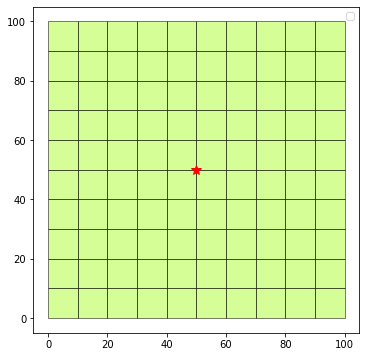

In [10]:
%matplotlib inline
ax = plotMesh(elements, nodes)
ax.plot(nodes[noeudSource].x, nodes[noeudSource].y, "*r", ms = 10)

In [11]:
# tests sur valeurs paramètres
print(f"CFL = {Δt/Δx}")
print(f"Δx = {Δx}m while λmin ~ {1/(4*f0)}")

CFL = 0.25
Δx = 2.0m while λmin ~ 4.0


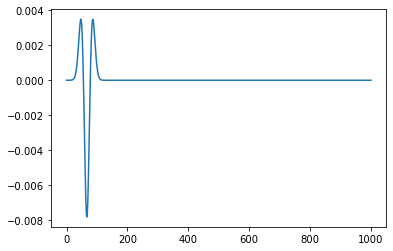

In [12]:
%matplotlib inline
plt.plot(time, f(time))

In [13]:
# FD
for i in tqdm(range(2,Nit)):
    F[noeudSource] = f(i*Δt)
    U[i,:] = 2*U[i-1,:] - U[i-2,:] + Δt**2*np.multiply(iM , F - K@U[i-1,:])

100%|██████████| 1998/1998 [00:01<00:00, 1044.87it/s]


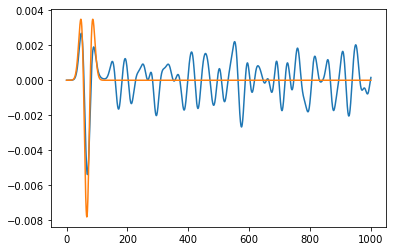

In [14]:
%matplotlib inline
plt.plot(time, U[:,noeudSource])
plt.plot(time, f(time))

In [15]:
import matplotlib.animation as animation

# %matplotlib widget
%matplotlib tk

In [18]:
fig, ax = plt.subplots()
ax.set_aspect("equal", "box")

# plotMeshLimits(elements, ax)

umin = min(U.min(), -U.max())/3

dots = ax.scatter([n.x for n in nodes], [n.y for n in nodes], c=U[0,:], zorder=4, cmap="seismic", vmin=umin, vmax=-umin)
cbar = plt.colorbar(dots)
ttl = ax.annotate("it = 0", xy=(0.05, 0.05), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='grey'), zorder=5)

dit = 5

def animate(i):
    dots.set_array(U[dit*i,:])
    cbar.update_normal(dots)
    ttl.set_text(f"it = {dit*i}")
    return dots,ttl,

ani = animation.FuncAnimation(fig, animate, interval=30, blit=True, frames = int(Nit/dit))

ani.event_source.start()

plt.show()

In [19]:
# plot interpolation bourrin : interpolation régulière sur l'élément de référence pour chaque élément puis interpolation "nearest" sur le nuage de point créé

def interpPlot(U, elements = elements, onlyZ = True):
    
    phi = shapeFunctions["P1"]["phi"]
    hij = lagrangian2D(N)
    
    npts = 10
        
    u = np.linspace(-1, 1, npts)
    uu, vv = np.meshgrid(u,u)
    vmin, vmax = U.min(), U.max()

    if not(onlyZ): X,Y = np.zeros(len(elements)*npts**2),np.zeros(len(elements)*npts**2)
    
    Z = np.zeros(len(elements)*npts**2)
    
    for i,e in enumerate(elements):
        
        coords = e.getCoords()
        
        zitp = interp(hij, [U[n.id] for n in e.nodes])
        Z[i*npts**2:(i+1)*npts**2] = zitp(uu, vv).reshape(npts**2)

        if not(onlyZ):
            xitp = interp(phi, coords[:,0])
            yitp = interp(phi, coords[:,1])
            X[i*npts**2:(i+1)*npts**2] = xitp(uu, vv).reshape(npts**2)
            Y[i*npts**2:(i+1)*npts**2] = yitp(uu, vv).reshape(npts**2)
            
    if onlyZ: return Z
    return X,Y,Z 

In [20]:
X,Y,Uitp0 = interpPlot(U[0,:],elements,False)

dit_interp = 5
U_list = [U[i,:] for i in range(1,Nit,dit_interp)]

with Pool(nprocesses) as p:
    Uitp = [Uitp0] + list(tqdm(p.imap(interpPlot, U_list), total=len(U_list)))

  1%|▏         | 5/400 [00:01<02:19,  2.83it/s]Exception ignored in: <function Variable.__del__ at 0x7f7968268430>
Traceback (most recent call last):
  File "/home/sylvain/anaconda3/lib/python3.8/tkinter/__init__.py", line 363, in __del__
    if self._tk.getboolean(self._tk.call("info", "exists", self._name)):
RuntimeError: main thread is not in main loop
Exception ignored in: <function Image.__del__ at 0x7f7968283d30>
Traceback (most recent call last):
  File "/home/sylvain/anaconda3/lib/python3.8/tkinter/__init__.py", line 4017, in __del__
    self.tk.call('image', 'delete', self.name)
RuntimeError: main thread is not in main loop
Exception ignored in: <function Image.__del__ at 0x7f7968283d30>
Traceback (most recent call last):
  File "/home/sylvain/anaconda3/lib/python3.8/tkinter/__init__.py", line 4017, in __del__
    self.tk.call('image', 'delete', self.name)
RuntimeError: main thread is not in main loop
Exception ignored in: <function Variable.__del__ at 0x7f7968268430>
Tracebac

In [20]:
fig, ax = plt.subplots()
ax.set_aspect("equal", "box")

# plotMeshLimits(elements, ax)

umin = min(U.min(), -U.max())/3

dots = ax.scatter(X, Y, c=Uitp[0], zorder=4, cmap="seismic", vmin=umin, vmax=-umin, marker=",")

cbar = plt.colorbar(dots)

ttl = ax.annotate("it = 0", xy=(0.05, 0.05), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='grey'), zorder=5)

dit = 2

def animate(i):
    dots.set_array(Uitp[dit*i])
    cbar.update_normal(dots)
    ttl.set_text(f"it = {dit_interp*dit*i}")
    return dots,ttl,

ani = animation.FuncAnimation(fig, animate, interval=100, blit=True, frames = len(Uitp))

ani.event_source.start()

plt.show()